Initializing model...


/Users/ebu/miniforge3/envs/deepdriving/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/ebu/miniforge3/envs/deepdriving/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fetching data...
Starting inference...


/Users/ebu/miniforge3/envs/deepdriving/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2890.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/ebu/miniforge3/envs/deepdriving/lib/python3.9/site-packages/torch/nn/functional.py:4171: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/ebu/miniforge3/envs/deepdriving/lib/python3.9/site-packages/torch/nn/functional.py:1906: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Inference took 1.7976861000061035s


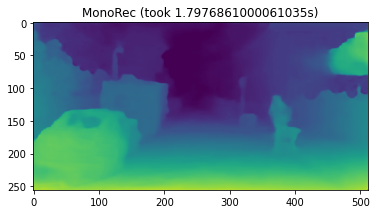

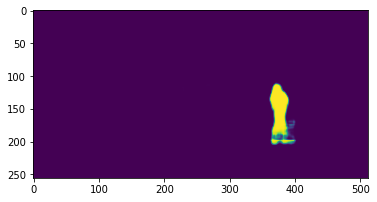

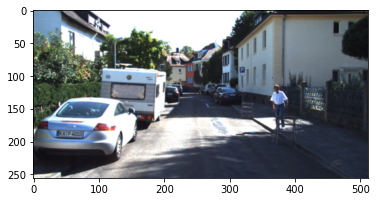

In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("/Users/ebu/Downloads/MonoRec-main")

from data_loader.kitti_odometry_dataset import KittiOdometryDataset
from model.monorec.monorec_model import MonoRecModel
from utils import unsqueezer, map_fn, to

target_image_size = (256, 512)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

dataset = KittiOdometryDataset("/Users/ebu/Downloads/MonoRec-main/example/data/kitti",sequences=["07"], target_image_size=target_image_size, frame_count=2,
                               depth_folder="image_depth_annotated", lidar_depth=True, use_dso_poses=True,
                               use_index_mask=None)

# Next three lines are a hack required because Kitti files are incomplete
dataset._dataset_sizes = [1000]
dataset._datasets[0].cam2_files = [f"/Users/ebu/Downloads/MonoRec-main/example/data/kitti/sequences/07/image_2/{i:06d}.png" for i in range(dataset._dataset_sizes[0])]
dataset._datasets[0].cam3_files = [f"/Users/ebu/Downloads/MonoRec-main/example/data/kitti/sequences/07/image_3/{i:06d}.png" for i in range(dataset._dataset_sizes[0])]

checkpoint_location = Path("/Users/ebu/Downloads/monorec_depth_ref.pth")

inv_depth_min_max = [0.33, 0.0025]

print("Initializing model...")
monorec_model = MonoRecModel(checkpoint_location=checkpoint_location, inv_depth_min_max=inv_depth_min_max)

monorec_model.to(device)
monorec_model.eval()

print("Fetching data...")
index = 164
# Corresponds to image index 169

batch, depth = dataset.__getitem__(index)
batch = map_fn(batch, unsqueezer)
depth = map_fn(depth, unsqueezer)

batch = to(batch, device)

print("Starting inference...")
s = time.time()
with torch.no_grad():
    data = monorec_model(batch)

prediction = data["result"][0, 0].cpu()
mask = data["cv_mask"][0, 0].cpu()
depth = depth[0, 0].cpu()

e = time.time()
print(f"Inference took {e - s}s")

plt.imsave("depth.png", prediction.detach().squeeze())
plt.imsave("mask.png", mask.detach().squeeze())
plt.imsave("kf.png", batch["keyframe"][0].permute(1, 2, 0).cpu().numpy() + 0.5)

plt.title(f"MonoRec (took {e - s}s)")
plt.imshow(prediction.detach().squeeze(), vmin=1 / 80, vmax=1 / 5)
plt.show()
plt.imshow(mask.detach().squeeze())
plt.show()
plt.imshow(batch["keyframe"][0].permute(1, 2, 0).cpu() + .5)
plt.show()
